# Visualization Code for Figure 3
## 0. Import Modules

In [3]:
import os
import torch
import numpy as np
import matplotlib.pyplot as plt
from torchmetrics.functional.pairwise import pairwise_cosine_similarity
from scipy.linalg import svdvals

color_dict = {
    "BSARec": "blue",
    "SASRec": "darkorange",
    "DuoRec": "green",
    "FMLPRec": "crimson"
}

## 1. Sequence Output

### Function `get_seqout`
- **Goal:**
    - Concatenate the output sequence for each layer so that we can obtain the output sequences for the entire test dataset.
- **Input:**
    - `save_path`: Path for the raw output sequence.
    - `n_layers`: Number of layers.
- **Output:**
    - `layers`: List of output sequences whose shape is (data_size, hidden_dim).

### How to Obtain Output Sequences?
- In the `forward` function for the transformer-based model in our repository, you can obtain the output sequences for all layers by setting `all_sequence_output=True`.

In [10]:
def get_seqout(save_path, n_layers=16):
    
    # Dictionary comprehension to initialize the layer data lists
    layer_dict = {i: [] for i in range(n_layers + 1)}

    # npy file name list
    file_lst = [os.path.join(save_path, f) for f in sorted(os.listdir(save_path))]

    # Load and append data for each layer
    for file in sorted(file_lst):
        layer_num = file.split('\\')[-1].split('layer_')[0] # format: "0layer_0iter.npy"
        layer_num = eval(layer_num)
        tmp = np.load(file)[:,-1,:]
        layer_dict[layer_num].append(tmp)
    
    # Concatenate the arrays for each layer
    layers = [np.concatenate(layer_dict[i]) for i in sorted(layer_dict.keys())]

    return layers

In [11]:
base_path = "./sequence_output/"
seqout = {
    "SASRec": get_seqout(base_path+"LastFM_SASRec", 16),
    "BSARec": get_seqout(base_path+"LastFM_BSARec", 16),
    "FMLPRec": get_seqout(base_path+"LastFM_FMLPRec", 16),
    "DuoRec": get_seqout(base_path+"LastFM_DuoRec", 16),
}

## 2. Cosine Similarity
- Compute the cosine similarity for every pair of output sequences in the test dataset and then average these pairwise similarities. 

In [12]:
def compute_cosine_similarity(seqout, return_numpy=True):
    
    seqout = torch.Tensor(seqout) # shape: (n_seq, hidden_dim)
    cos_sim = pairwise_cosine_similarity(seqout) # shape: (n_seq, n_seq)
    cos_sim = cos_sim.mean()
    
    return cos_sim.item()

cos_sim_dict = {}
for model in seqout.keys():
    cos_sim_dict[model] = list(map(lambda x: compute_cosine_similarity(x), seqout[model]))

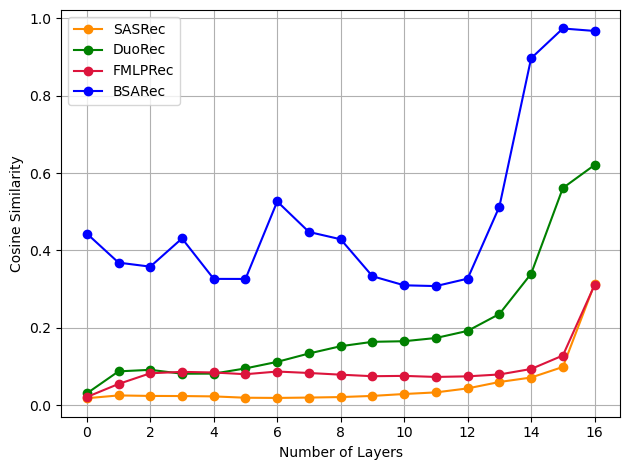

In [13]:
for model in ['SASRec', 'DuoRec', 'FMLPRec', 'BSARec']:
    plt.plot(range(0,17), cos_sim_dict[model], label=model, marker='o', color=color_dict[model])

plt.xlabel('Number of Layers')
plt.ylabel('Cosine Similarity')
plt.legend(loc='upper left')
plt.grid(visible=True)

plt.tight_layout()
plt.show()

## 3. Singular Value
- Compute the singular values of a matrix and divide each of them by the largest value to obtain the normalized singular values.

In [6]:
svs_dict = {}
for model in seqout.keys():
    x = seqout[model][-1]
    svs_dict[model] = svdvals(x)/(svdvals(x).max())

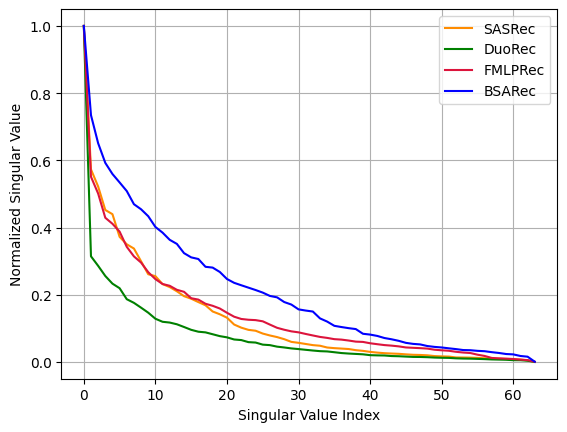

In [7]:
for model in ['SASRec', 'DuoRec', 'FMLPRec', 'BSARec']:
    plt.plot(svs_dict[model], label=model, color=color_dict[model])

plt.xlabel('Singular Value Index')
plt.ylabel('Normalized Singular Value')
plt.legend(loc='upper right')
plt.grid(visible=True)

plt.show()